# notes
* Set up the GPU for OpenCL and create a GPU Context 

In [1]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

# notes
* Make a GPU kernel for linear wave equation

In [3]:
%%cl_kernel 
__kernel void linearwave_eq_2D(__global float *u2,__global float *u1, __global const float *u0,
float c, float dt, float dx, float dy) {
    
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    int i = get_global_id(0); 
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i; 
    int south = (j-1)*nx + i; 
    int east = j*nx + i + 1;
    int west = j*nx + i -1;
    
    //Internal cells
    if (i > 0 && i < nx-1 && j > 0 && j <ny-1) {
        u2[center] = 2*u1[center] - u0[center] 
                    + c*dt*dt/(dx*dx) * (u1[west]-2*u1[center]+u1[east])
                    + c*dt*dt/(dy*dy) * (u1[south]-2*u1[center]+u1[north]);
    }
   
}

/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx' on 'Intel(R) OpenCL' at 0x22c29d8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <linearwave_eq_2D> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)


# notes
* Another kernel for boundaries conditions

In [12]:
%%cl_kernel 
__kernel void linear_wave_2D_bc(__global float* u) {
    
    int nx = get_global_size(0); 
    int ny = get_global_size(1);
    int i = get_global_id(0); 
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i; 
    int south = (j-1)*nx + i; 
    int east = j*nx + i + 1;
    int west = j*nx + i -1;
    
    if (i == 0) {
        u[center] = u[east];
    }
    else if (i == nx-1) {
        u[center] = u[west];
    }
    else if (j == 0) {
        u[center] = u[north];
    }
    else if (j == ny-1) {
        u[center] = u[south];
    }
}

/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx' on 'Intel(R) OpenCL' at 0x22c29d8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <linear_wave_2D_bc> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)
/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: From-binary build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx' on 'Intel(R) OpenCL' at 0x22c29d8> succeeded, but said:

Device build started
Device build done
Reload Program Binary Object.
  warn(text, CompilerWarning)


# notes
* Initial Conditions and move data from CPU to GPU

In [13]:
nx = 100
ny =50
c = 1.0
dx = 1.0
dy = 2.0
dt = 0.2 * min(dx / (2.0*c), dy / (2.0*c))

u0 = np.zeros((ny, nx), dtype=np.float32)
for j in range(ny):
    for i in range(nx):
        x = (i - nx/2.0) * dx
        y = (j - ny/2.0) * dy
        if (np.sqrt(x**2 + y**2) < 10*min(dx, dy)):
            u0[j, i] = 10.0
u1 = np.copy(u0)

mf = cl.mem_flags

#Upload data to the device
u0_g = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
#Allocate output buffers
u1_g = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
u2_g = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)

# notes 
* Run the kernel and download the results

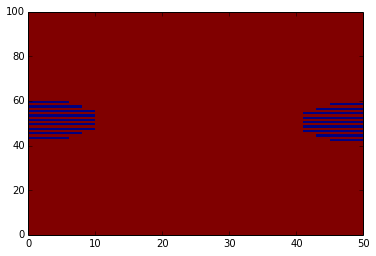

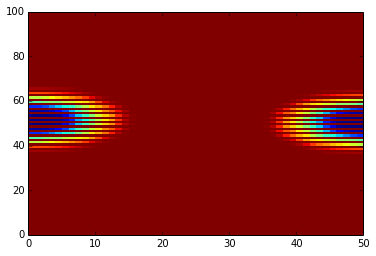

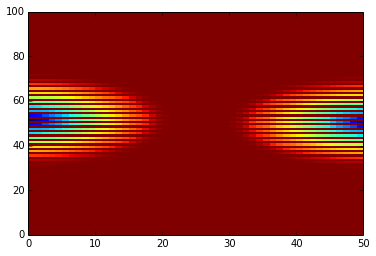

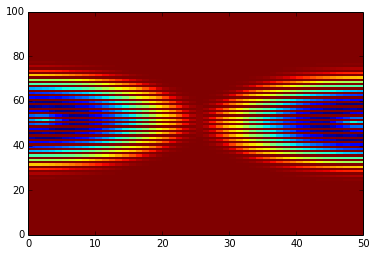

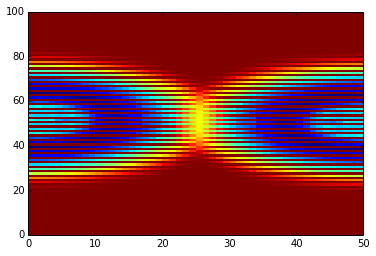

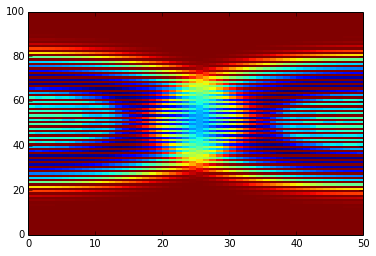

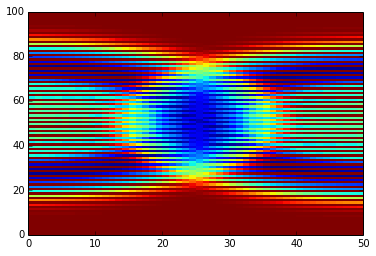

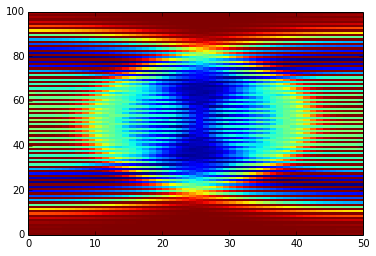

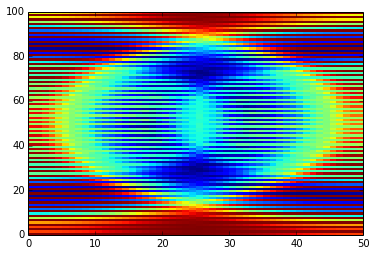

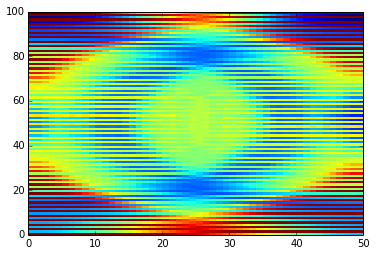

In [14]:



nt = 500
for i in range(0, nt):
    #Execute program on device
    linearwave_eq_2D(cl_queue, (nx,ny), None, u2_g, u1_g, u0_g, numpy.float32(c), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
    #Impose boundary conditions
    linear_wave_2D_bc(cl_queue, (nx, ny), None, u2_g)
    #Swap variables
    u0_g, u1_g, u2_g = u1_g, u2_g, u0_g
    
    #Plot results
    if (i % 50 == 0):
        figure()
        u0 = np.empty((nx, ny), dtype=np.float32)
        cl.enqueue_copy(cl_queue, u0, u1_g)
        pcolor(u0)
    
    
    



